In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import os 
import re
from functions13 import * 

path = "../Data/casper/"
c = np.load(path +'calib.npy', allow_pickle=True).item()

K0 = c["K0"]
d0 = c["d0"]
K1 = c['K1']
d1 = c['d1']
R = c['R']

imgs0,imgs1 = load_and_sort(path + 'sequence/')

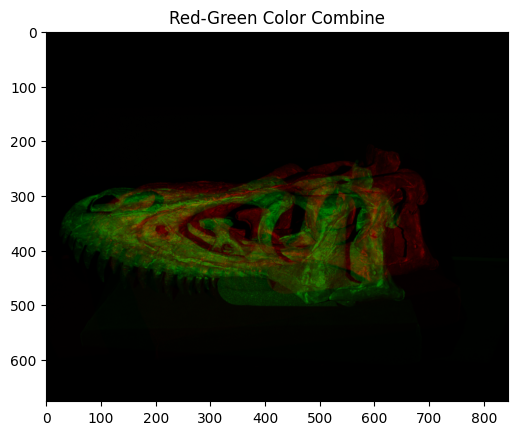

In [2]:
color_combine(imgs0[0],imgs1[0])

## Exercise 13.1
 * If the cameras were not calibrated, you would need to calibrate them first.
 - How would you find their intrinsics?
 - What about the extrinsics?

### Exercise 13.2
 for each image,
 * load it,
 * convert it floating point and gray-scale, and
 * rectify it

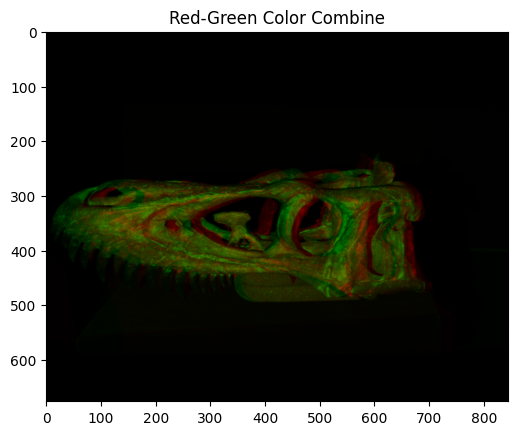

In [3]:
im0 = cv2.imread( path + "sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

imgs0,imgs1 = rectify_all_images(maps0,maps1,imgs0,imgs1)
color_combine(imgs0[0],imgs1[0])

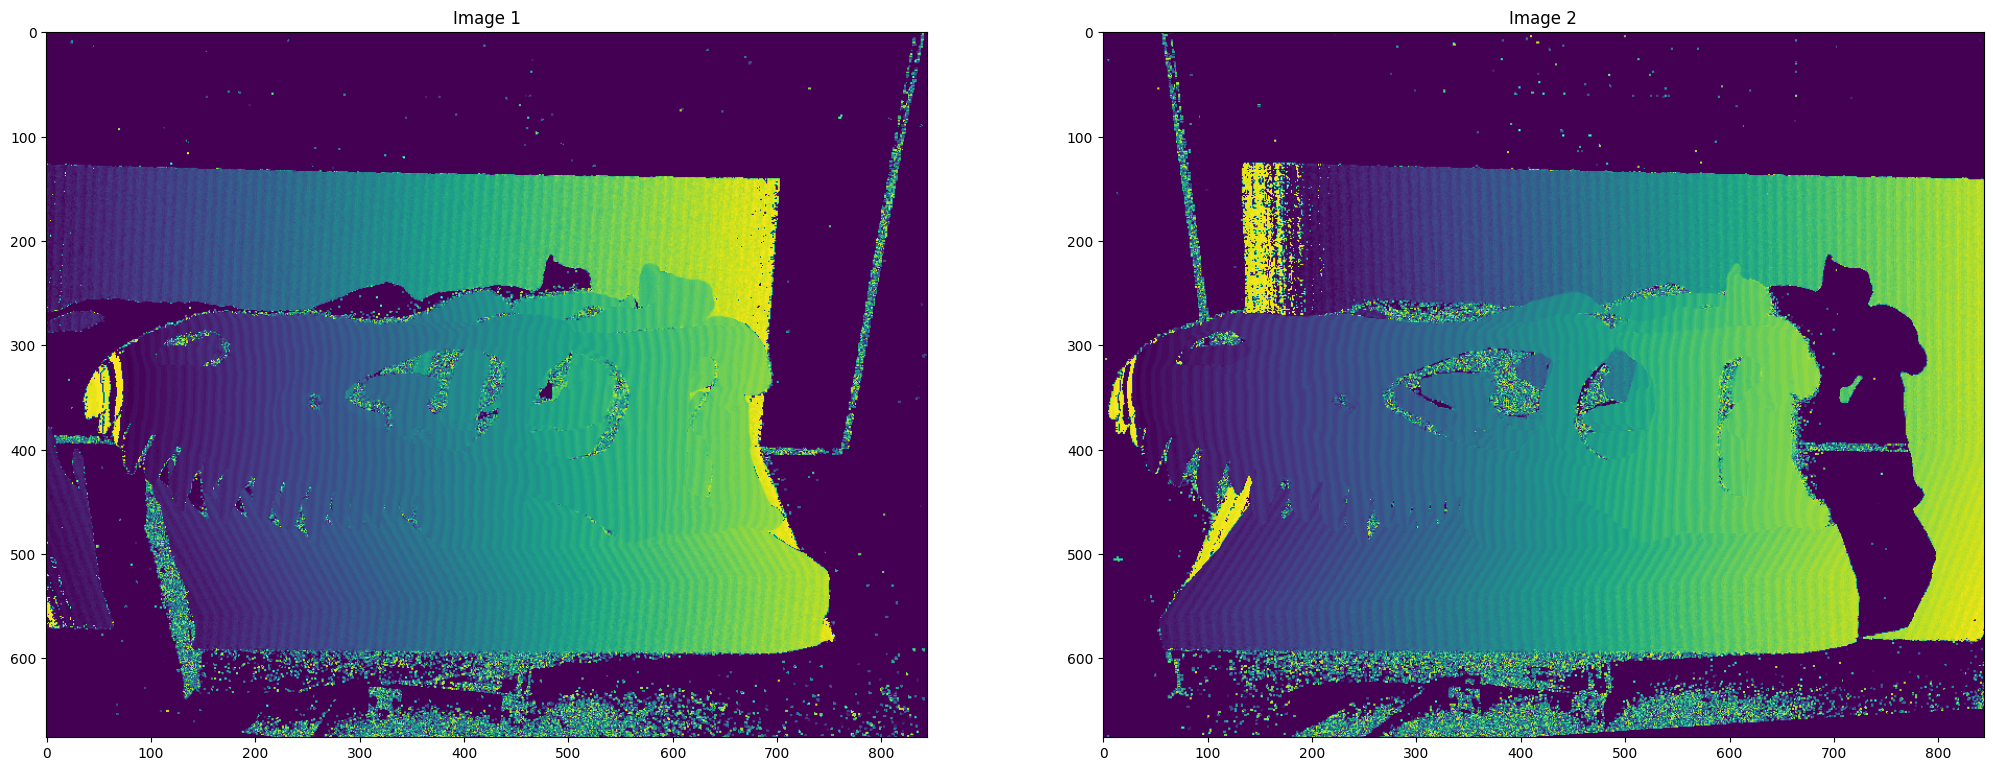

In [4]:
theta0,theta1 = unwrap(imgs0,n1=40),unwrap(imgs1,n1=40)
plot_two_images(theta0,theta1,False)

### Exercise 13.4
 * When inspecting the phase images theta0 and theta1 it is clear that not all pixels contain a
 valid measurement of the phase. This is because some pixels do not reflect enough light from the
 projector to give a meaningful measurement. 
 * To fix this we introduce a binary mask that contains the areas that are sufficiently illuminated by the projector. 
 * Subtract the fully on and fully off projector image from each other (the first two elements of ims), to obtain a measurement of how
 much projector light is in each pixel.

 * Apply a threshold to this difference image to obtain a mask for each camera (mask0 and mask1).

 - I suggest using a threshold of 15.

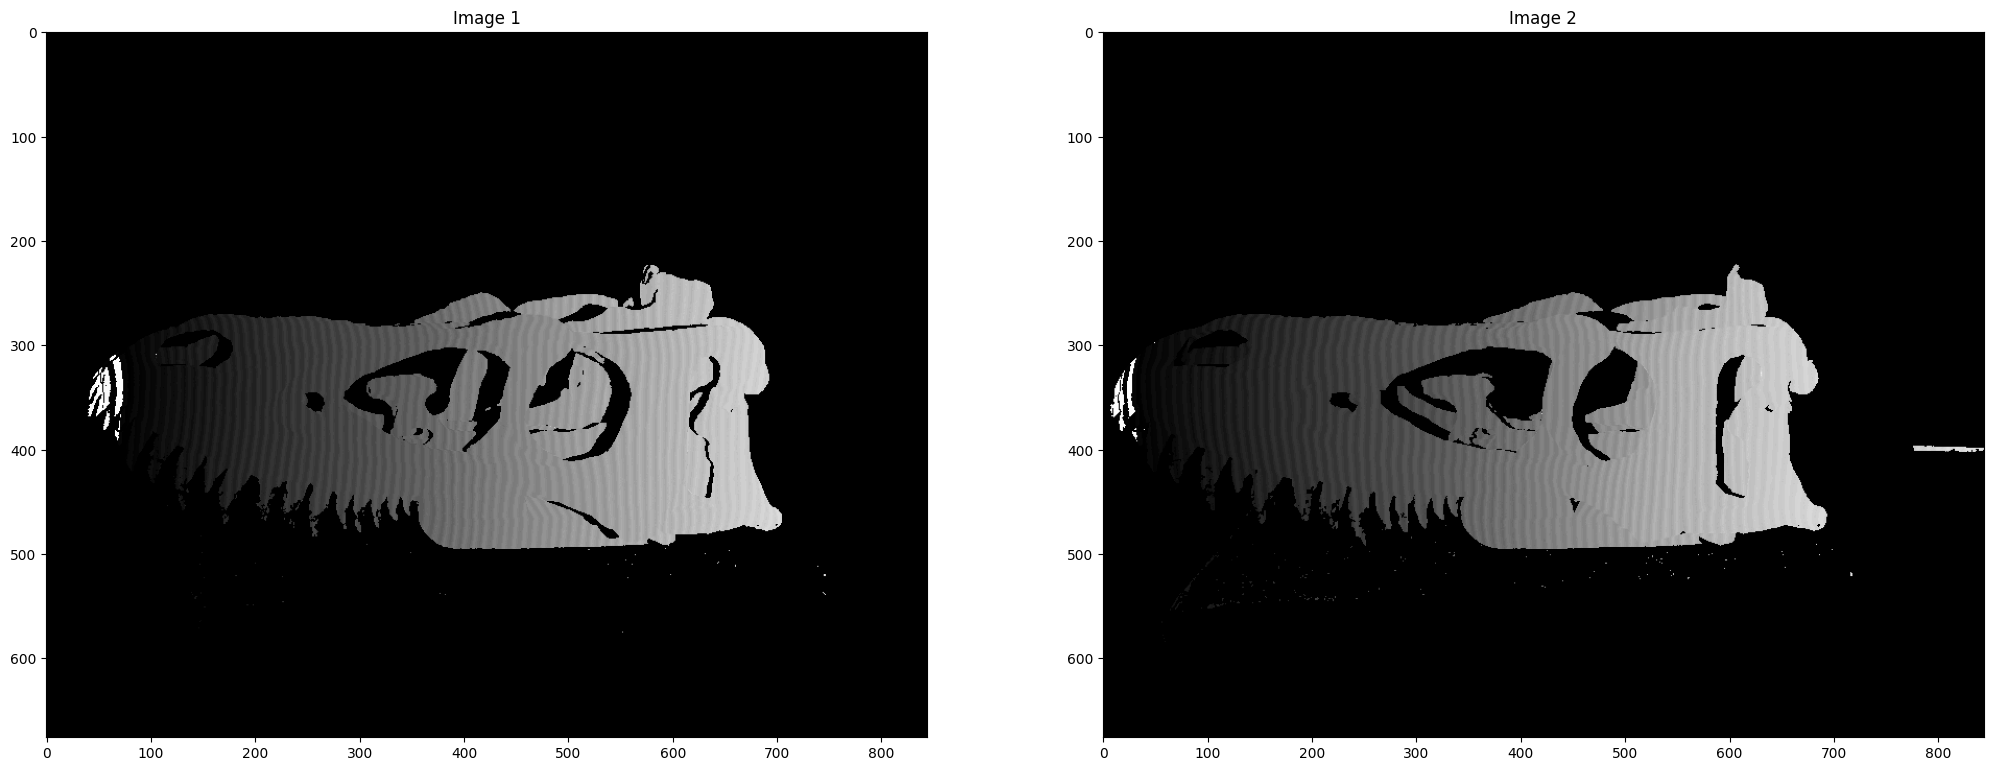

In [5]:
diff_0 = np.abs(imgs0[0]-imgs0[1])
diff_1 = np.abs(imgs1[0]-imgs1[1])

threshold = 15.0/255 # scale it between 0 and 1
binary_mask1 = diff_0>threshold
binary_mask2 = diff_1>threshold

plot_two_images(theta0*binary_mask1,theta1*binary_mask2,True)

### Exercise 13.5
 * Now we need to find matches between the two cameras. As the images are rectified, we can constrain ourselves to search for a match on the corresponding row in the other image. That is we need to create two lists (q0s and q1s) that contain the pixel coordinates of matches between camera 0 and 1.
 * Use a double for-loop to iterate over all pixels in camera 0. For each valid pixel (mask0[i0,j0] = True which has the phase theta0[i0,j0]), we need to find the pixel in the other image that matches the best. As the images are rectified the epipolar line is a the row i0 in camera 1. Thus, we find the matching pixel in camera 1, selecting the pixel from row i0 which is valid mask1[i0,j1]
 = True and which has the closest phase match: theta0[i0,j0] ∼ theta1[i0,j1].
 Be aware that the points have to be of the form (x,y) i.e. [j, i], in order to work with our
 projection matrices.

 * To verify your matches you can compute the disparity image. This is the image such that
 disparity[i0,j0] = j0-j1 for all valid pixels. Initialize it with 0 everywhere, and fill it where you have matches.

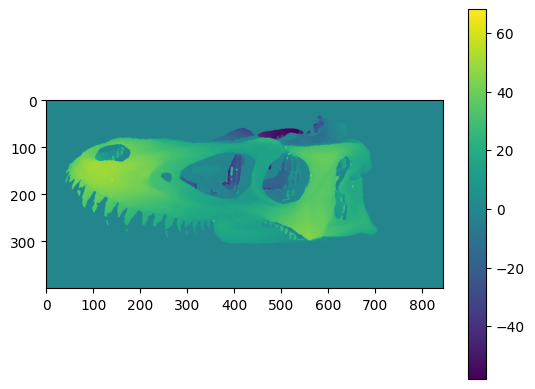

In [6]:
qs0,qs1,disparity = find_stereo_matches(theta0,theta1,binary_mask1,binary_mask2)
plt.imshow(cv2.medianBlur(disparity.astype(np.float32),5)[190:590])
plt.colorbar()

In [7]:
qs0_ = np.array(qs0).T.astype(np.float32)
qs1_ = np.array(qs1).T.astype(np.float32)
Q = cv2.triangulatePoints(P0,P1,qs0_,qs1_)
Q  = Q[:3]/Q[3]
Q = Q[:, Q[2] > 0]

In [8]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
#pcd.colors = o3d.utility.Vector3dVector(colors0)  # Assign colors to the points
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
